# ResNet on MIT Indoor Scene Recognition From Scratch
- Save all import package: Pytorch, Python version
- DeepDream Play Ground
- Pretrain ResNet: <<< This does not work for pretrained ResNet
    - Load and Test on Local Machine 
    - Apply Deep Dream on Pretrain ResNet
- Train ResNet From Scratch Ben Trevett
    - Load and Test on Local Machine
    - Apply Deep Dream 
    - Make Gif, Video
- Make application
- Write Report: Compare result on pretrained ImageNet, MIT, Place365. If have time, train the Inception V3,...

In [73]:
import os 
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

from model.resnet import Bottleneck
from model.resnet import ResNet
from model.resnet import ResNet50

## 1. Dataset Import
- There are 67 Indoor categories with a total of 15620 images. The number of images varies across categories, but there are at least 100 images per category. All images are in jpg format. 

In [74]:
!ls ../../data/indoorCVPR_09/Images

airport_inside	computerroom	     inside_subway   pantry
artstudio	concert_hall	     jewelleryshop   poolinside
auditorium	corridor	     kindergarden    prisoncell
bakery		deli		     kitchen	     restaurant
bar		dentaloffice	     laboratorywet   restaurant_kitchen
bathroom	dining_room	     laundromat      shoeshop
bedroom		elevator	     library	     stairscase
bookstore	fastfood_restaurant  livingroom      studiomusic
bowling		florist		     lobby	     subway
buffet		gameroom	     locker_room     toystore
casino		garage		     mall	     trainstation
children_room	greenhouse	     meeting_room    tv_studio
church_inside	grocerystore	     movietheater    videostore
classroom	gym		     museum	     waitingroom
cloister	hairsalon	     nursery	     warehouse
closet		hospitalroom	     office	     winecellar
clothingstore	inside_bus	     operating_room


In [75]:
data_dir = '../../data/indoorCVPR_09/Images'
classes = os.listdir(data_dir)
print(f"There are {len(classes)} classes: \n {classes}")

There are 67 classes: 
 ['videostore', 'warehouse', 'bookstore', 'operating_room', 'meeting_room', 'mall', 'bar', 'auditorium', 'kitchen', 'restaurant', 'fastfood_restaurant', 'gym', 'bathroom', 'subway', 'closet', 'hospitalroom', 'clothingstore', 'casino', 'gameroom', 'restaurant_kitchen', 'nursery', 'grocerystore', 'shoeshop', 'movietheater', 'bowling', 'bedroom', 'corridor', 'poolinside', 'children_room', 'hairsalon', 'dining_room', 'classroom', 'jewelleryshop', 'laboratorywet', 'elevator', 'stairscase', 'concert_hall', 'winecellar', 'tv_studio', 'garage', 'airport_inside', 'florist', 'artstudio', 'prisoncell', 'computerroom', 'library', 'museum', 'waitingroom', 'toystore', 'lobby', 'buffet', 'church_inside', 'deli', 'office', 'dentaloffice', 'bakery', 'cloister', 'studiomusic', 'livingroom', 'kindergarden', 'laundromat', 'pantry', 'inside_subway', 'trainstation', 'locker_room', 'inside_bus', 'greenhouse']


## 2. Data Transformations

In [76]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()]) #256

dataset = ImageFolder(data_dir, transform = transformations)

In [77]:
# Helper function to see the image and labels
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: airport_inside (Class No: 0)


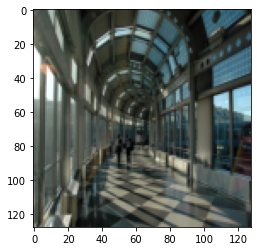

In [78]:
img, label = dataset[50]
show_sample(img, label)

## 3. Load and Split Dataset

In [79]:
random_seed = 42
torch.manual_seed(random_seed)

In [80]:
len(dataset)

15620

In [81]:
train_set, val_set, test_set = random_split(dataset, [13000, 2000, 620])
len(train_set), len(val_set), len(test_set)

(13000, 2000, 620)

In [82]:
from torch.utils.data.dataloader import DataLoader
batch_size = 25 # 25

In [83]:
# Create training and validating dataloaders with DataLoader
trainloader = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
valloader = DataLoader(val_set, batch_size, num_workers = 4, pin_memory=True)

In [84]:
# Visualize batches
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        print(images[0].shape)
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

torch.Size([3, 128, 128])


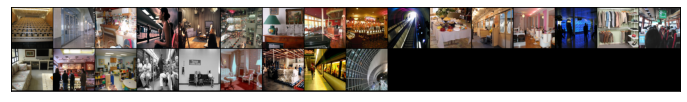

In [85]:
show_batch(trainloader)

torch.Size([3, 128, 128])


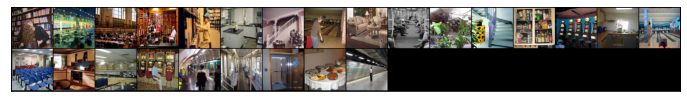

In [86]:
show_batch(valloader)

In [87]:
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
# #     transforms.RandomCrop(32, padding=4), 
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])

In [88]:
# train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# trainloader = torch.utils.data.DataLoader(train, batch_size=25, shuffle=True, num_workers=2)

# test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# testloader = torch.utils.data.DataLoader(test, batch_size=25,shuffle=False, num_workers=2)

In [89]:
# show_batch(trainloader)

In [90]:
# print(train[0][0].shape)

In [91]:
# classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## 4. ResNet50

In [92]:
net = ResNet50(67).to('cpu')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [93]:
# EPOCHS = 10
# for epoch in range(EPOCHS):
#     losses = []
#     running_loss = 0
#     for i, inp in enumerate(trainloader):
#         inputs, labels = inp
#         inputs, labels = inputs.to('cpu'), labels.to('cpu')
#         optimizer.zero_grad()
    
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         losses.append(loss.item())

#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
        
#         if i%100 == 0 and i > 0:
#             print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
#             running_loss = 0.0

#     avg_loss = sum(losses)/len(losses)
#     scheduler.step(avg_loss)
#     print(f"Loss: {avg_loss}")
            
# print('Training Done')

## 5. Save Model

In [94]:
!ls

deepdream_pretrained_resnet.ipynb  resnet_pretrain_loader.ipynb
__init__.py			   resnet_scratch_classifier.ipynb
model				   saved_models
resnet_pretrain_classifier.ipynb   utils


In [95]:
path = "./saved_models/resnet50_scratch.pth"
torch.save(net.state_dict(), path)

## 6. Test Load

In [96]:
new_net = ResNet50(67).to('cpu')
new_net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [97]:
new_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): Batch

## 7. Evaluate 

In [98]:
correct = 0
total = 0

with torch.no_grad():
    for data in valloader:
        images, labels = data
        images, labels = images.to('cpu'), labels.to('cpu')
        outputs = new_net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on 2000 validation images: ', 100*(correct/total), '%')

RuntimeError: The size of tensor a (256) must match the size of tensor b (64) at non-singleton dimension 1